In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

from utils.visualize import *
from utils.FIR_filter import *
from utils.signal_process import *
from utils.preprocess import *

import pickle

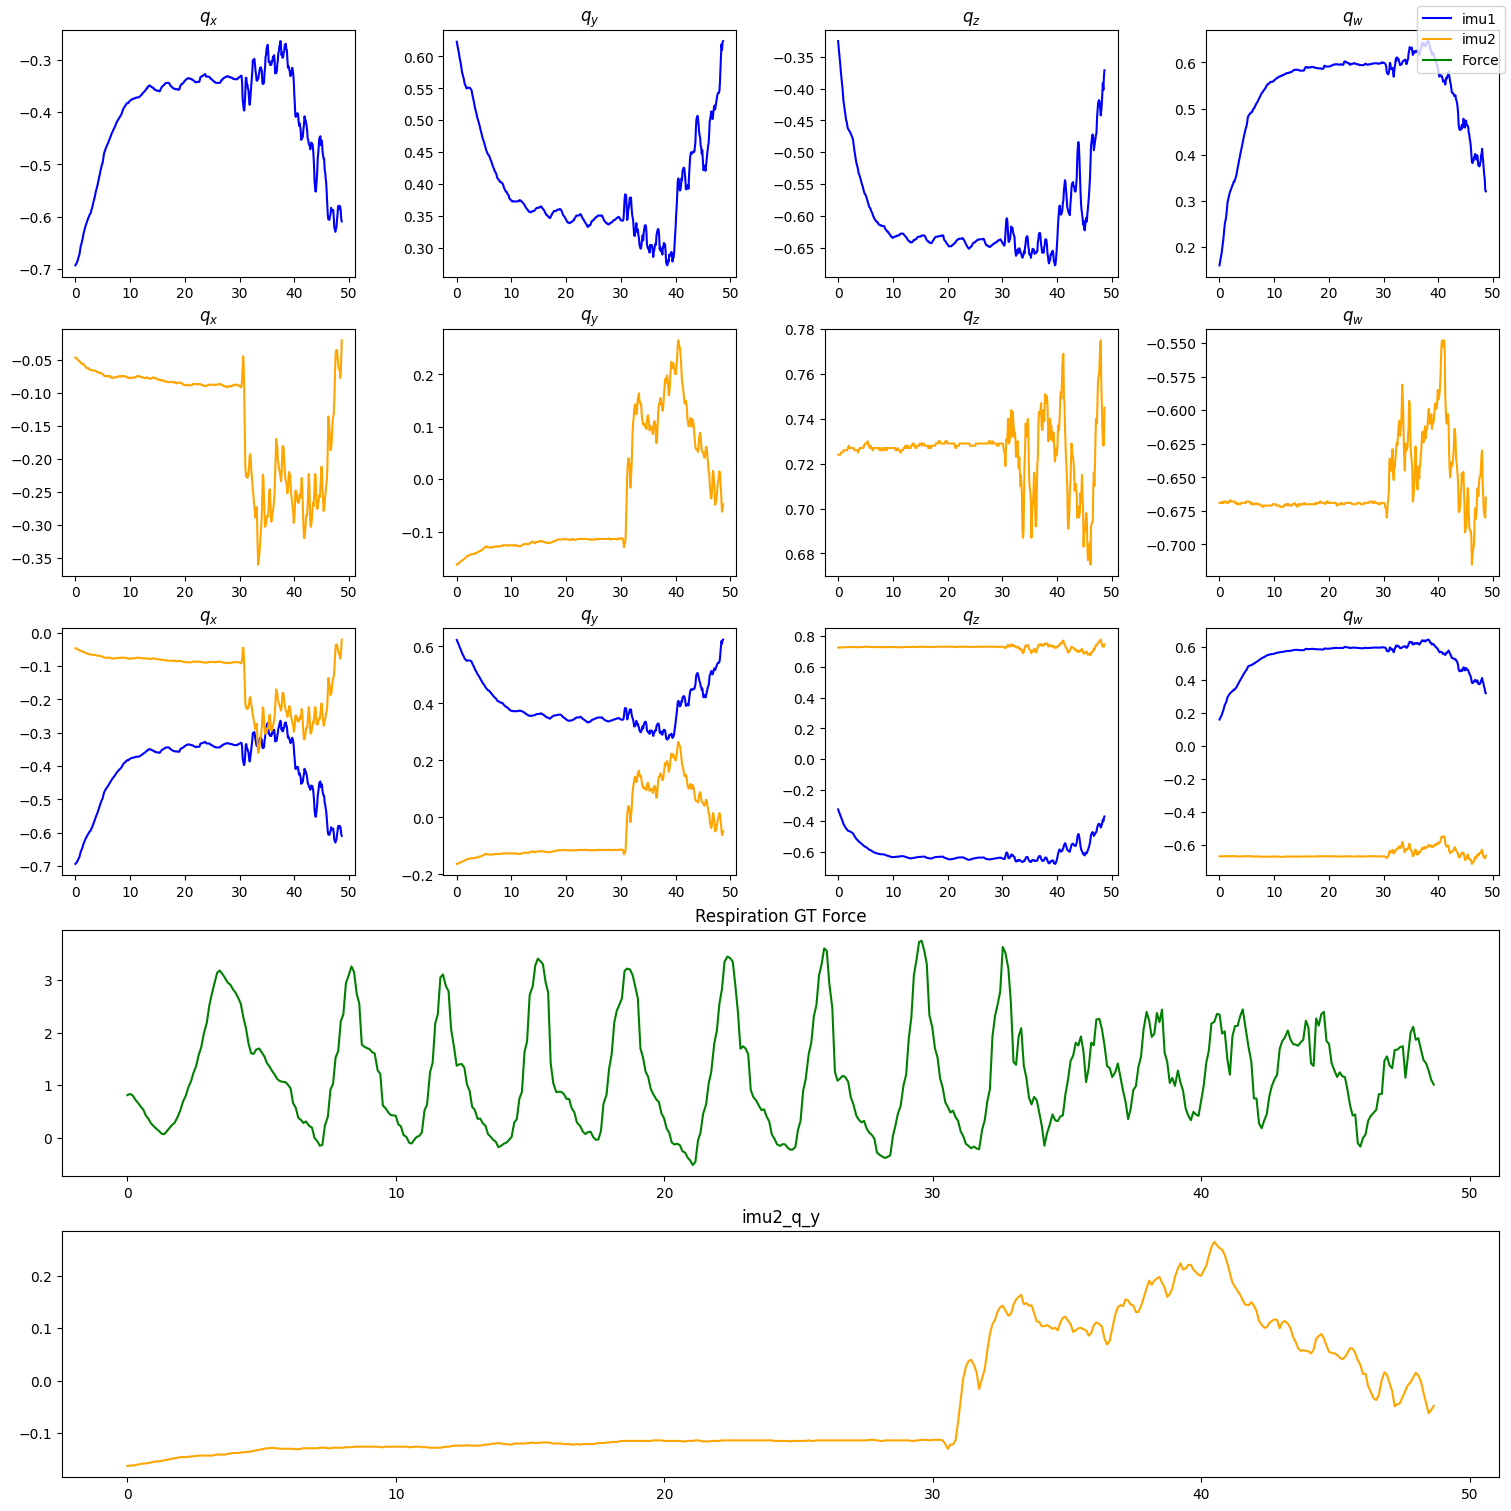

In [9]:
fs = 10
start_pt, end_pt = 0, 600
still_pt = 300 # 500

file_path = "./data/hamham/train/walk_stand_4.csv" 
# file_path = "./data/3_28/walk_stand_0328_0236.csv" 

data = pd.read_csv(file_path)
data.columns = [
    "Timestamp",
    "imu1_q_x",
    "imu1_q_y",
    "imu1_q_z",
    "imu1_q_w",
    "imu2_q_x",
    "imu2_q_y",
    "imu2_q_z",
    "imu2_q_w",
    "Force",
    "RR",
]
sensor_names=['imu1','imu2']
cols = ['q_x', 'q_y', 'q_z', 'q_w']
data = data.iloc[start_pt:end_pt]

data = align_delay(data, delay=10)
data["Timestamp"] = pd.to_datetime(data["Timestamp"])
data = data.set_index("Timestamp")

draw_imu_curve(data, overlap=True, show_gt=True)
# draw_imu_curve(data, overlap=True, show_gt=False)

best_score/total: 187/300


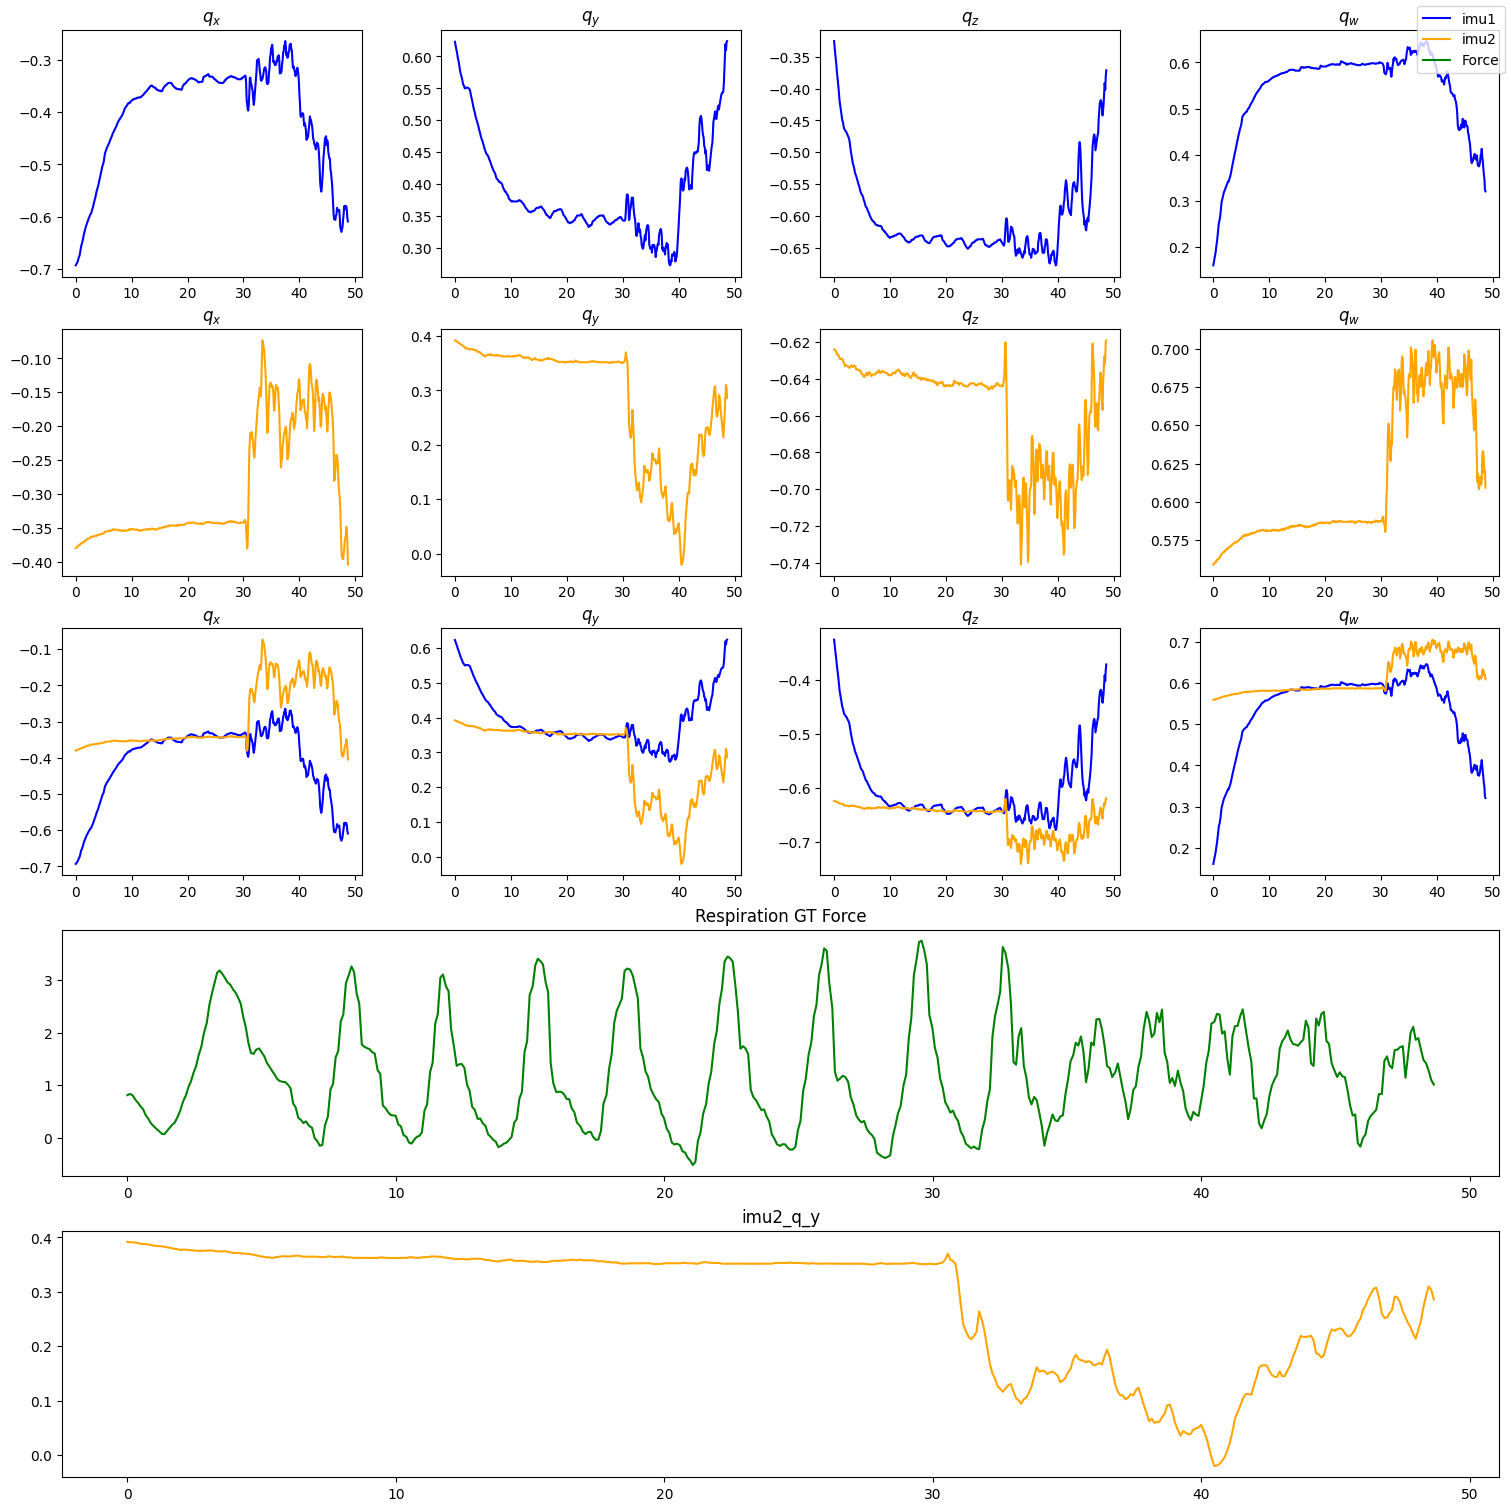

In [10]:
# Align IMUs (IMU2 -> IMU1)
q_corr = Q_RANSAC(data[0:still_pt], pool=1.0, d=0.05)

target, skew = 'imu1', 'imu2'
Q_skew = data[[skew + '_q_x', skew + '_q_y', skew + '_q_z', skew + '_q_w']].to_numpy()
Q_aligned = align_quaternion(q_corr, Q_skew) # (sample num, 4)
data_aligned = data.copy()

for i, col in enumerate(cols):
    data_aligned[[skew + '_' + col]] = Q_aligned[:, i].reshape(-1, 1)

draw_imu_curve(data_aligned, overlap=True, show_gt=True)

In [ ]:
# q1, q2:(x, y, z, w)
def calculate_omega(q1, q2, dt):
    return (2 / dt) * np.array([
        q1[3]*q2[0] - q1[0]*q2[3] - q1[1]*q2[2] + q1[2]*q2[1],
        q1[3]*q2[1] + q1[0]*q2[2] - q1[1]*q2[3] - q1[2]*q2[0],
        q1[3]*q2[2] - q1[0]*q2[1] + q1[1]*q2[0] - q1[2]*q2[3]])

# q:(sample num, 4)
def q_to_omega(q, fs=10):
    omega = np.zeros((q.shape[0], 3))
    dt = 1/fs
    for i in range(1, q.shape[0]):
        omega[i] = calculate_omega(q[i], q[i-1], dt)

    omega[0] = omega[1]
    
    return omega

# omega:(sample num, 3)
def omega_to_AngSpeed(omega):
    return np.linalg.norm(omega, axis=1)

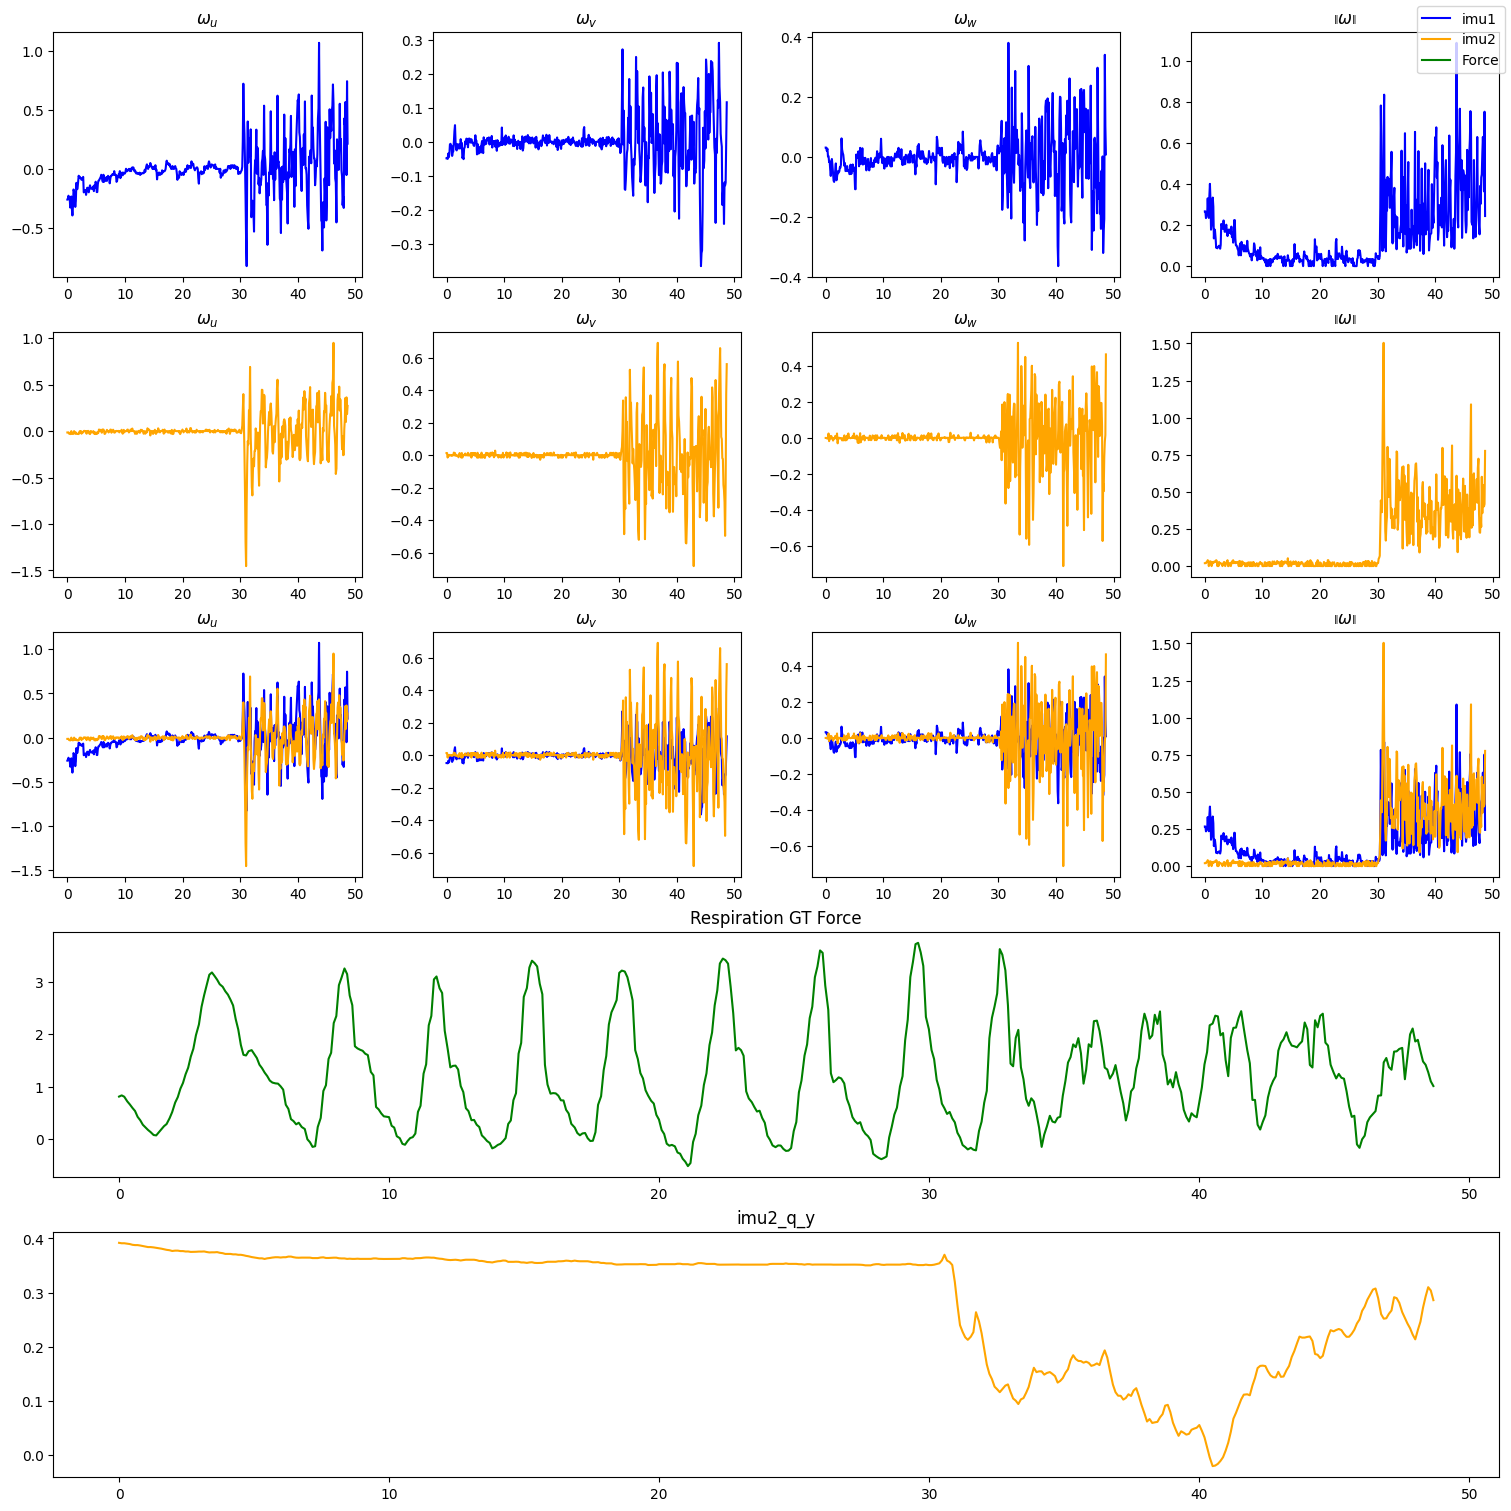

In [ ]:
omega_axes = ['\omega_u', '\omega_v', '\omega_w']
for imu in sensor_names:
    q = data_aligned[[imu + "_" + "q_x", imu + "_" + "q_y", imu + "_" + "q_z", imu + "_" + "q_w"]].values # (sample num, 4)
    omega = q_to_omega(q)
    ang_speed = omega_to_AngSpeed(omega)
    for i, omega_axis in enumerate(omega_axes):
        data_aligned[imu + "_" + omega_axis] = omega[:, i]
    
    data_aligned[imu + "_" + '\left\|\omega\\right\|'] = ang_speed
# draw_imu_curve(data_aligned, cols=omega_axes, overlap=True, show_gt=True)
draw_imu_curve(data_aligned, cols=omega_axes+['\left\|\omega\\right\|'], overlap=True, show_gt=True)

In [13]:
data_aligned[:5]

,imu1_q_x,imu1_q_y,imu1_q_z,imu1_q_w,imu2_q_x,imu2_q_y,imu2_q_z,imu2_q_w,Force,RR,imu1_\omega_u,imu1_\omega_v,imu1_\omega_w,imu1_\left\|\omega\right\|,imu2_\omega_u,imu2_\omega_v,imu2_\omega_w,imu2_\left\|\omega\right\|
Timestamp,,,,,,,,,,,,,,,,,,
2025-03-27 07:54:50.968637,-0.693,0.623,-0.325,0.161,-0.379801,0.391999,-0.624129,0.559062,0.808083,NaN,-0.26056,-0.04828,0.03108,0.266812,-0.014475,0.013375,-0.000940,0.019731
2025-03-27 07:54:51.064966,-0.691,0.618,-0.335,0.168,-0.379795,0.391192,-0.624133,0.559628,0.831078,NaN,-0.26056,-0.04828,0.03108,0.266812,-0.014475,0.013375,-0.000940,0.019731
2025-03-27 07:54:51.160372,-0.689,0.614,-0.344,0.174,-0.378906,0.391240,-0.624578,0.559699,0.805534,NaN,-0.22768,-0.05018,0.02060,0.234053,-0.013377,-0.014477,-0.003239,0.019975
2025-03-27 07:54:51.272622,-0.687,0.609,-0.353,0.181,-0.378009,0.390481,-0.625026,0.560336,0.716103,NaN,-0.24834,-0.03442,0.02750,0.252218,-0.027855,-0.001100,-0.004199,0.028191
2025-03-27 07:54:51.368231,-0.684,0.605,-0.362,0.188,-0.377112,0.389720,-0.625472,0.560972,0.657341,NaN,-0.24490,-0.04510,0.00158,0.249023,-0.027861,-0.001100,-0.004200,0.028198
